<a href="https://colab.research.google.com/github/lukasztracz195/DeepLearningInPythonCourse/blob/main/Lab1_catvsdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cat and Dogs Implementacja 
Podstawą zadanie jest zbudowanie własnego datasetu, bazującego na koncepcji cats vs dogs. Należy przygotować zestaw zdjęć dwóch kategorii (klas), w którym elementy są do siebie podobne, ale jednocześnie możliwe jest rozróżnienie pomiędzy nimi (np. koty i psy, ogórki i cukinie itp.

Korzystanie z gotowych datasetów nie jest zalecane, ale dopuszczalne (przygotowanie własnego problemu będzie lepiej punktowane).

Na podstawie przygotowanych danych należy opracować sieć konwolucyjną, która pozwoli na rozpoznawanie obiektów tych klas.

Opracowane rozwiązanie musi zawierać:

1. Callbacki: Warunek early Stopping i zapisywanie checkpointów
2. Data augmentation (zwiększanie ilości danych poprzez modyfikację obrazów w locie - generator)





In [15]:
import os
import shutil 
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
from keras.callbacks import *
import tensorflow as tf 
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks_list = [model_checkpoint_callback]

In [18]:
%%bash
rm -rf /content/*

rm: cannot remove '/content/drive': Is a directory
rm: cannot remove '/content/gdrive/MyDrive': Operation canceled
rm: cannot remove '/content/gdrive/.shortcut-targets-by-id': Operation canceled


In [19]:
%%bash
pwd
wget --output-document=cats_and_dogs.zip --quiet https://ml-repository-krakers.s3-eu-west-1.amazonaws.com/kaggle+/cats_and_dogs/dogs-vs-cats.zip
ls

/content
cats_and_dogs.zip
drive
gdrive


### Wypakowanie danych

In [20]:
%%bash
pwd

/content


In [21]:
%%bash
pwd
ls
unzip cats_and_dogs.zip
# rm -rf cats_and_dogs.zip

rm -rf sampleSubmission.csv

unzip -q train.zip -d /content/kaggle_original_data
rm -rf train.zip
cp /content/kaggle_original_data/train/* /content/kaggle_original_data/
rm -rf /content/kaggle_original_data/train

unzip -q /content/test1.zip
# rm -rf test1.zip
# rm -rf cats_and_dogs.zip
ls

/content
cats_and_dogs.zip
drive
gdrive
Archive:  cats_and_dogs.zip
  inflating: sampleSubmission.csv    
  inflating: train.zip               
  inflating: test1.zip               
cats_and_dogs.zip
drive
gdrive
kaggle_original_data
test1
test1.zip


In [22]:
def make_accuracy_plot(history):
  """
  Funckja zwraca wykres dokładności (accuracy) modelu na zbiorze treningowym i walidacyjnym.
  """

  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
  epochs = range(1, len(acc)+1)

  plt.figure(figsize=(10,8))
  plt.plot(epochs, acc, label='Dokladność trenowania', marker='o')
  plt.plot(epochs, val_acc, label='Dokladność walidacji', marker='o')
  plt.legend()
  plt.title('Dokładność trenowania i walidacji')
  plt.xlabel('Epoki')
  plt.ylabel('Dokładność')
  plt.show()

In [23]:
def make_loss_plot(history):
  """
  Funkjca zwraca wykres straty (loss) modelu na zbiorze treningowym
  i walidacyjnym
  """

  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()
  loss, val_loss = history.history['loss'], history.history['val_loss']
  epochs = range(1, len(loss)+ 1)

  plt.figure(figsize = (10,8))
  plt.plot(epochs, loss, label='Strata trenowania', marker='o')
  plt.plot(epochs, val_loss, label="Strata walidacji", marker='o')
  plt.legend()
  plt.title('Strata trenowania i walidacji')
  plt.xlabel('Epoki')
  plt.ylabel('Strata')
  plt.show()

In [24]:
def display_augment_images(directory, index):
  """
  Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki augumentacji danych.
  """

  fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
  img_path = fnames[index]
  img = image.load_img(img_path, target_size=(150,150))

  x = image.img_to_array(img)
  x = x.reshape((1, ) + x.shape)

  i=1
  plt.figure(figsize=(20, 14))
  for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3,4,i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i +=1
    if i % 13 == 0:
      break;

###Przygotowanie katalogów

In [25]:
# ścieżka do oryginalnego zbioru
original_dataset_dir = '/content/kaggle_original_data'
# katalog, w którym umieścimy nasze dane
base_dir = '/content/cats_and_dogs'

if not os.path.exists(base_dir):
  os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for directory in (train_dir, valid_dir, test_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

dirs = [train_cats_dir, train_dogs_dir, valid_cats_dir, valid_dogs_dir, test_cats_dir, test_dogs_dir]
for directory in dirs:
  if not os.path.exists(directory):
    os.mkdir(directory)


In [26]:
#rozdielamy zdjęcia kotów
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(valid_cats_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

#rodzielamy zdjęcia psów
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(valid_dogs_dir, fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

In [27]:
print('Liczba kotów - zbiór treningowy', len(os.listdir(train_cats_dir)))
print('Liczba kotów - zbiór walidadyjny', len(os.listdir(valid_cats_dir)))
print('Liczba kotów - zbiór testowy', len(os.listdir(test_cats_dir)))

print('Liczba psów - zbiór treningowy', len(os.listdir(train_dogs_dir)))
print('Liczba psów - zbiór walidadyjny', len(os.listdir(valid_dogs_dir)))
print('Liczba psów - zbiór testowy', len(os.listdir(test_dogs_dir)))

Liczba kotów - zbiór treningowy 1000
Liczba kotów - zbiór walidadyjny 500
Liczba kotów - zbiór testowy 500
Liczba psów - zbiór treningowy 1000
Liczba psów - zbiór walidadyjny 500
Liczba psów - zbiór testowy 500


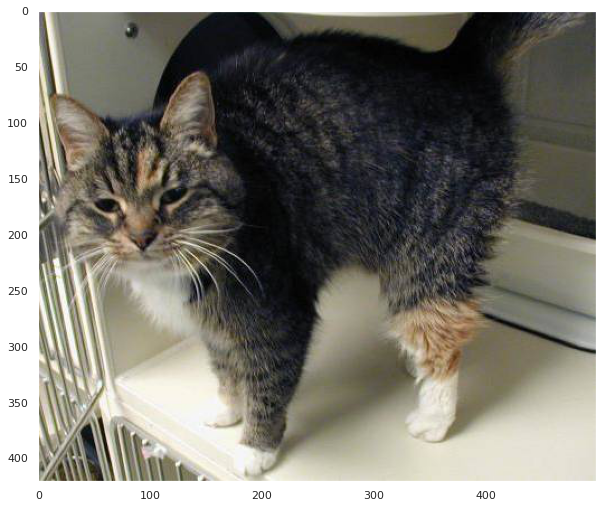

In [28]:
#@title. Wybierz indeks przykładowego zdjęcia kota:
from keras.preprocessing import image

index = 793 #@param { type:'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/cats/cat.' + str(index) + '.jpg'
img = image.load_img(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)

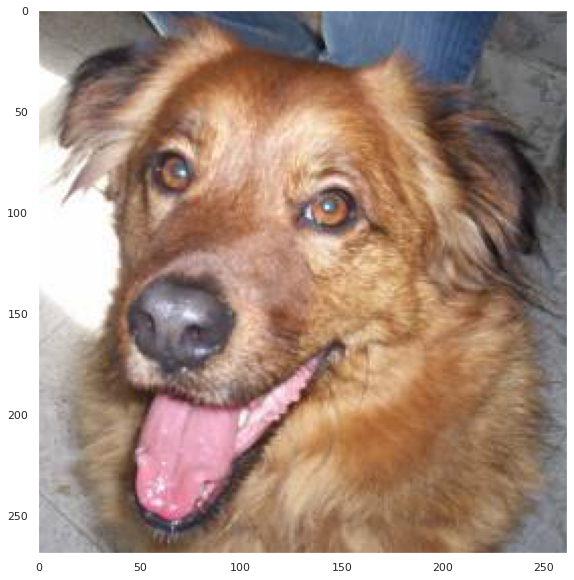

In [29]:
#@title. Wybierz indeks przykładowego zdjęcia psa:
from keras.preprocessing import image

index = 660 #@param { type:'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/dogs/dog.' + str(index) + '.jpg'
img = image.load_img(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)

### Budowa modelu

In [30]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [13]:
from keras import optimizers
model.compile(optimizer=optimizers.SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

###Przetworzenie danych do modelu


In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                     target_size = (150,150),
                                                     batch_size=20,
                                                     class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                     target_size = (150,150),
                                                     batch_size=20,
                                                     class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Sprawdzenie poprawności kształtu danych treningowych

In [33]:
for data_batch, labels_batch in train_generator:
  print('Kształ danych wsadowych: ', data_batch.shape)
  print('Kształt etykiet danych wsadowych:', labels_batch.shape)
  break

Kształ danych wsadowych:  (20, 150, 150, 3)
Kształt etykiet danych wsadowych: (20,)


###Dopasowanie modelu (bez_augumentacji danych)

In [34]:
import time
tic = time.time()
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=valid_generator,
                              validation_steps=50,
                              callbacks = model_checkpoint_callback
                              )
toc = time.time()
print('Czas przetwrzania: {}'.format(toc - tic))
model.save('cats_and_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6925 - accuracy: 0.5105 - val_loss: 0.6915 - val_accuracy: 0.5020
Epoch 2/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6900 - accuracy: 0.5370 - val_loss: 0.6897 - val_accuracy: 0.5030
Epoch 3/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6877 - accuracy: 0.5485 - val_loss: 0.6879 - val_accuracy: 0.5920
Epoch 4/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6851 - accuracy: 0.5520 - val_loss: 0.6863 - val_accuracy: 0.5650
Epoch 5/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6818 - accuracy: 0.5885 - val_loss: 0.6824 - val_accuracy: 0.5790
Epoch 6/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6799 - accuracy: 0.5825 - val_loss: 0.6793 - val_accuracy: 0.5950
Epoch 7/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6757 - accuracy: 0.5880 - val_loss: 0.6746 - val_accuracy: 0.6000

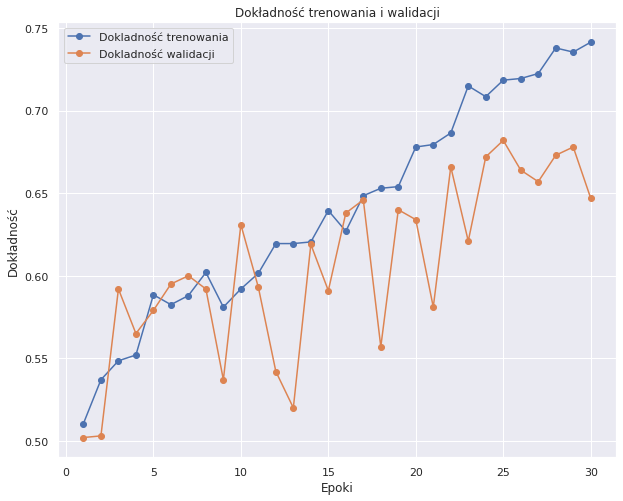

In [35]:
make_accuracy_plot(history)

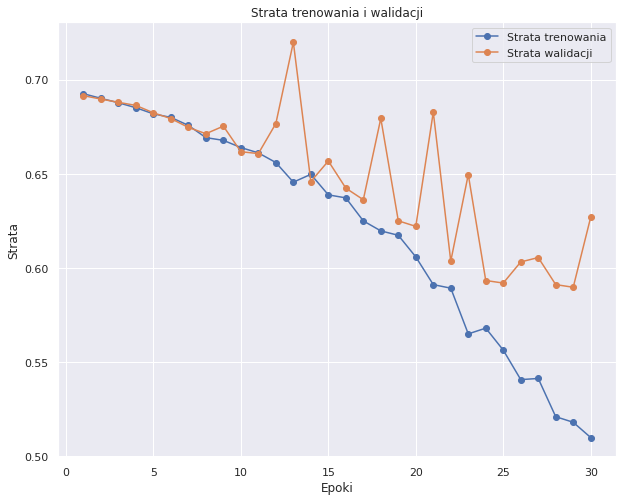

In [36]:
make_loss_plot(history)

# Wnioski

### Na powyższych wykresach jesteśmy wstanie dostrzeć zjawisko overfitingu, które jest widoczne po 10 epokach

# Zastosowanie augumentacji danych

In [52]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range =0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest')

### Wyświetlenie kilku przyładów augumentacji - koty

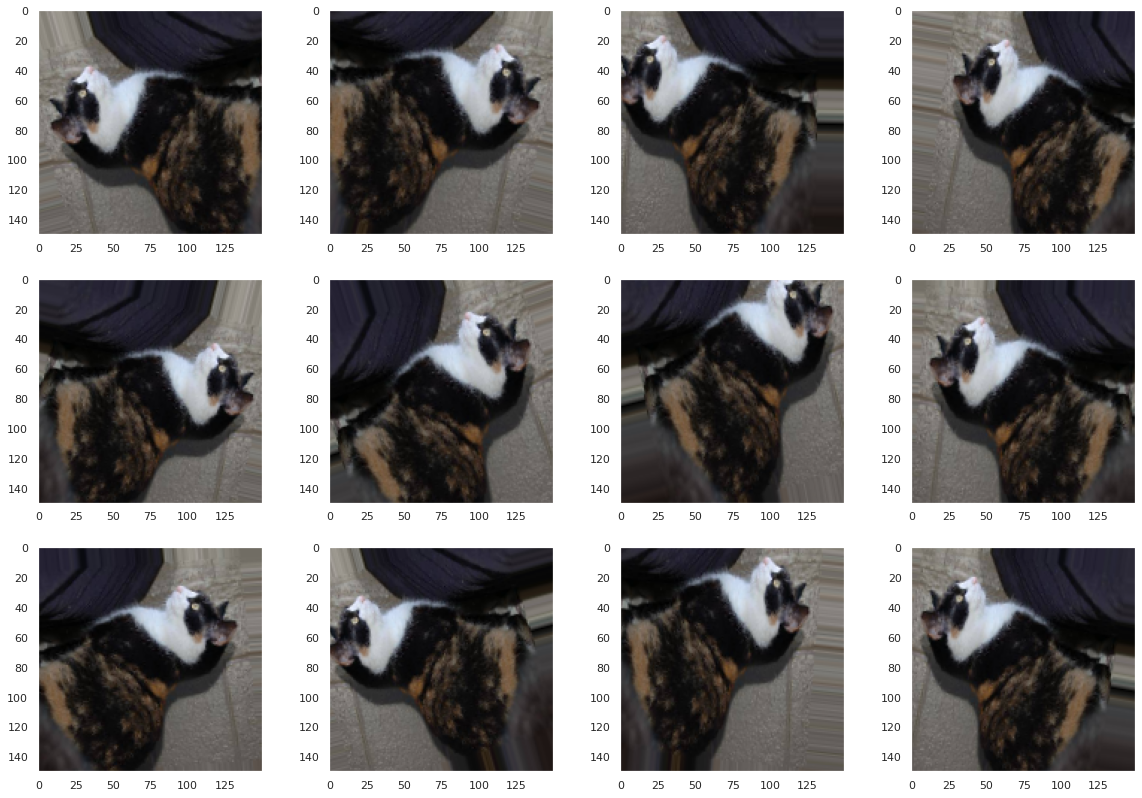

In [53]:
#@title Wybierz index obrazka w celu jego eksploracji
from keras.preprocessing import image

index = 95 #@param { type:'slider', min:0, max:999}
display_augment_images(train_cats_dir, index)

### Wyświetlenie kilku przyładów augumentacji - psy

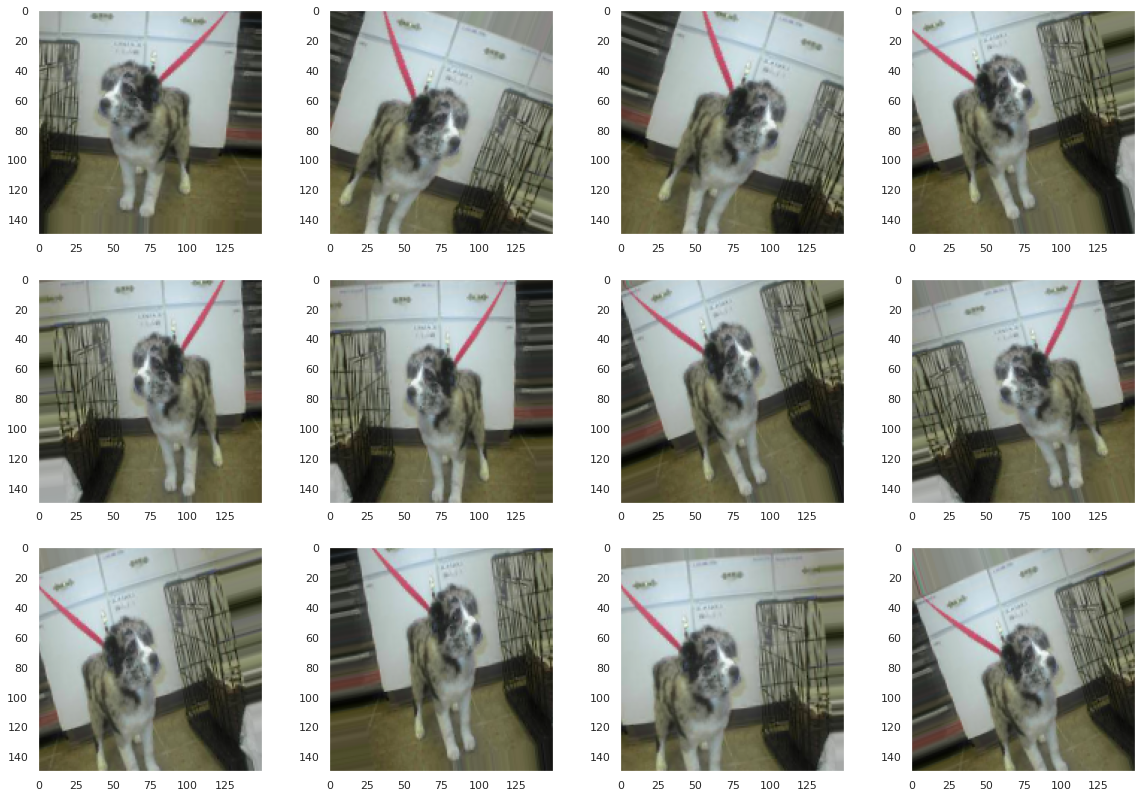

In [54]:
#@title Wybierz index obrazka w celu jego eksploracji
from keras.preprocessing import image

index = 833 #@param { type:'slider', min:0, max:999}
display_augment_images(train_dogs_dir, index)

###Trenowanie konwolucyjnej sieci neuronowej z wykorzystaniem obrazów wygenerowanych z użyciem augumentacji danych

In [40]:
from keras import layers
from keras import models
# przetestować ze zmniejszonymi paramterami augumentacji
# pozmieniać wartości filtrów w warstwach konwolucyjnych

# ostatecznie rozbudować dataset
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)      

In [45]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range =0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

# nie  modyfikujemy danych walidacyjnych
valid_datagen = ImageDataGenerator(rescale= 1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150,150),
                                                    batch_size=16,
                                                    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150,150),
                                                    batch_size=16,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [46]:
for data_batch, labels_batch in train_generator:
  print('Kształ danych wsadowych: ', data_batch.shape)
  print('Kształt etykiet danych wsadowych:', labels_batch.shape)
  break

Kształ danych wsadowych:  (16, 150, 150, 3)
Kształt etykiet danych wsadowych: (16,)


In [47]:
%%bash
python3 -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 3

2.3.0


2020-12-07 15:01:03.650723: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


### Trenowanie modelu

In [48]:
#history = model.fit(X_train, y_train, batch_size=128, epochs=20,validation_data=(X_test, y_test))
warnings.filterwarnings('ignore')
history = model.fit(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=valid_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 16s 161ms/step - loss: 0.6995 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 2/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6956 - accuracy: 0.5131 - val_loss: 0.6962 - val_accuracy: 0.5088
Epoch 3/100
100/100 [==============================] - 16s 161ms/step - loss: 0.6959 - accuracy: 0.5019 - val_loss: 0.7039 - val_accuracy: 0.5013
Epoch 4/100
100/100 [==============================] - 16s 161ms/step - loss: 0.6974 - accuracy: 0.4919 - val_loss: 0.7010 - val_accuracy: 0.4950
Epoch 5/100
100/100 [==============================] - 16s 161ms/step - loss: 0.6962 - accuracy: 0.4837 - val_loss: 0.6989 - val_accuracy: 0.4875
Epoch 6/100
100/100 [==============================] - 16s 161ms/step - loss: 0.6974 - accuracy: 0.4944 - val_loss: 0.6963 - val_accuracy: 0.4850
Epoch 7/100
100/100 [==============================] - 16s 158ms/step - loss: 0.6955 - accuracy: 0.5019 - val_loss: 0.7012 -

### Zapisanie modelu do pliku

In [49]:
model.save('cats_and_dogs_small_2.h5')

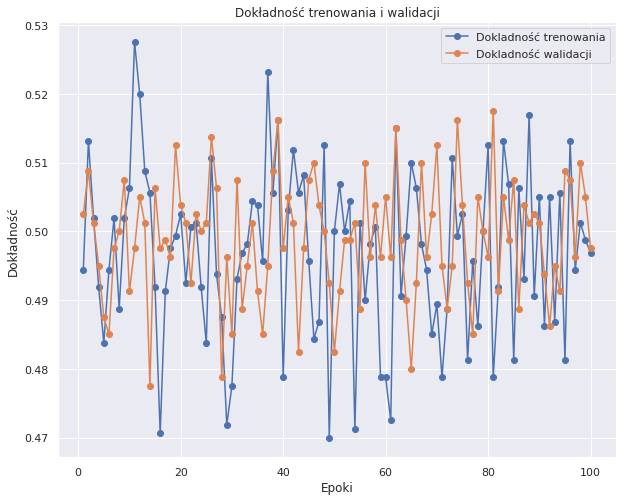

In [50]:
make_accuracy_plot(history)

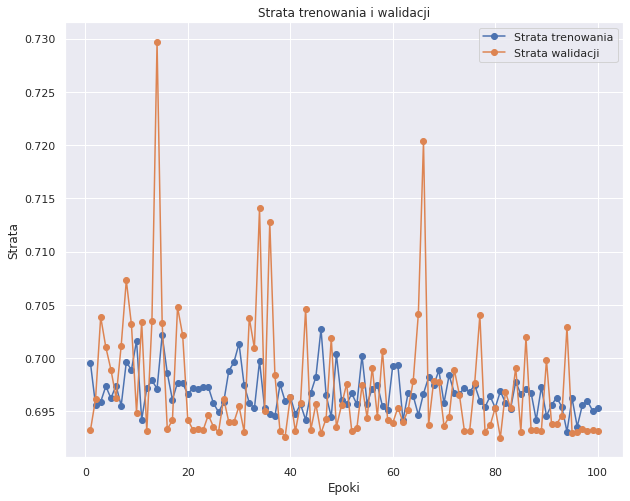

In [51]:
make_loss_plot(history)

# Podjęcie próby trenowania hiperparametrów

### Import bibliotek

In [2]:
!pip install hyperas
!pip install talos

In [5]:
%%bash
git clone https://github.com/keras-team/keras-tuner.git
cd keras-tuner
pip install .

Processing /content/keras-tuner
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-cp36-none-any.whl size=92439 sha256=0a78ec4739c7852cb6536926765790a0071fc60660e683e058f9ed936e8fb2a0
  Stored in directory: /root/.cache/pip/wheels/fa/4e/d0/ed331a3363786e8a74848aa0589674f502cbb3f0321cdba844
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=35234f96913c2dfdcab76824d09728951f7651e507855c6b700bf5fa9102b946
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


Cloning into 'keras-tuner'...


In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras 
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [7]:
tuner = RandomSearch(
    model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='train_dir',
    project_name='Cats vs Dogs')

tuner.search_space_summary()

tuner.search(data_batch, label_batch,
             epochs=1,
             validation_data=valid_generator)
             

models = tuner.get_best_models(num_models=2)

NameError: ignored